In [2]:
import os
import glob
import sys
sys.path.append('/Users/aghavamp/Desktop/Projects')
sys.path.append('/Users/aghavamp/Desktop/Projects/bimanual_wrist')
sys.path.append('/Users/aghavamp/Desktop/Projects/Functional_Fusion')
sys.path.append('/Users/aghavamp/Desktop/Projects/PcmPy')
import getpass
import importlib
from tqdm import tqdm
from pathlib import Path

import rsatoolbox as rsa
from rsatoolbox.io import spm as spm_io
import surfAnalysisPy as surf
import SUITPy as suit
import nibabel as nb
import nitools as nt
import PcmPy as pcm
import Functional_Fusion.atlas_map as am
import Functional_Fusion.reliability as rel

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.cm import ScalarMappable
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.patches as patches
import seaborn as sns

import scipy.stats as stats
import scipy
import scipy.io as sio
import numpy as np
import pandas as pd

import utils
importlib.reload(utils)

# SET PATHS:
baseDir = os.path.join('/Users', getpass.getuser(), 'Desktop', 'Projects', 'bimanual_wrist', 'data', 'fMRI')
bidsDir = 'BIDS'
anatomicalDir = 'anatomicals'
freesurferDir = 'surfaceFreesurfer'
surfacewbDir = 'surfaceWB' 
behavDir = 'behavioural'
regDir = 'ROI'
atlasDir = '/Volumes/diedrichsen_data$/data/Atlas_templates/fs_LR_32'
analysisDir = os.path.join(os.path.dirname(os.path.dirname(baseDir)), 'analysis')



# 12by12 Unimanual Representation

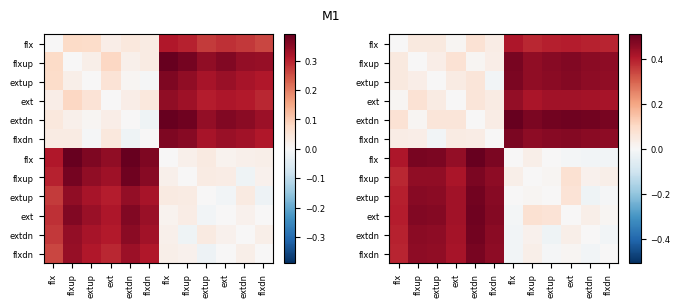

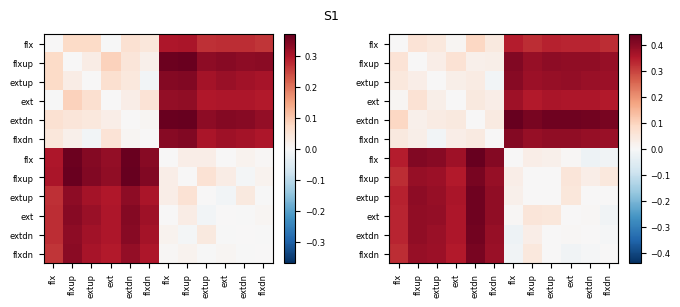

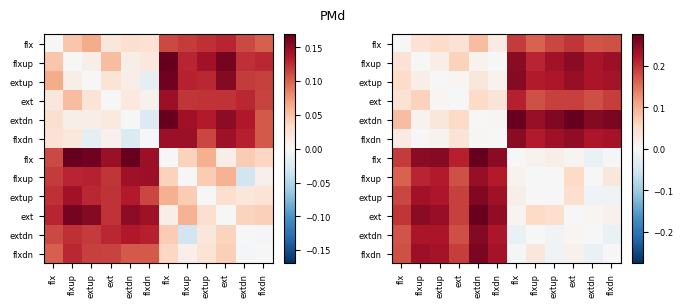

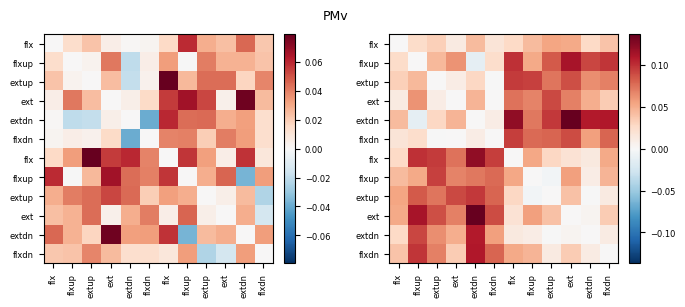

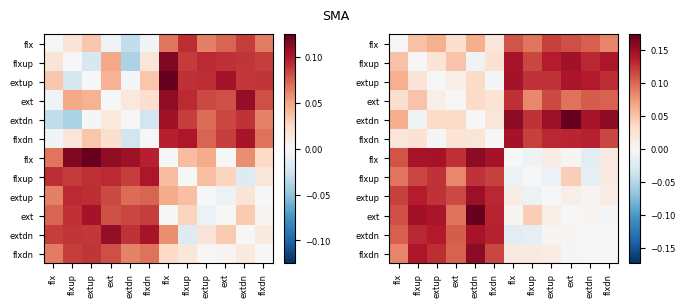

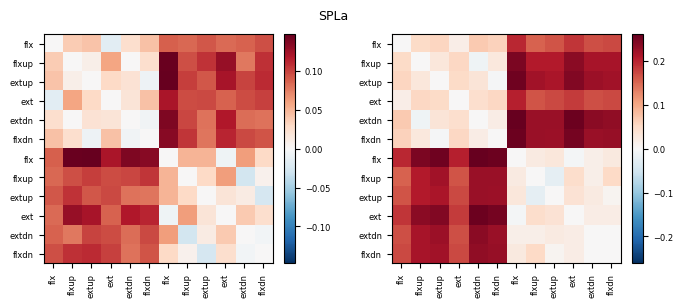

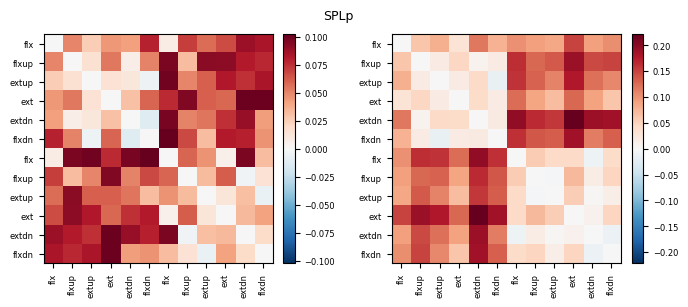

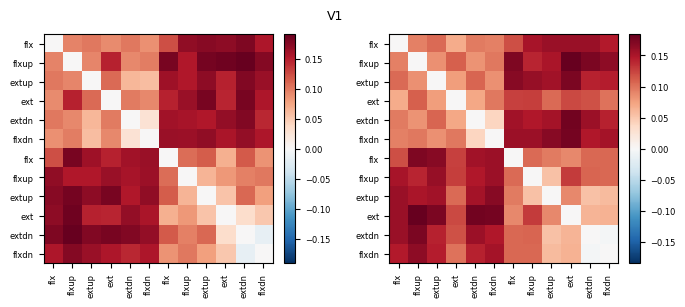

In [3]:
labels = ['flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn', 'flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn']
labels_lateral = ['contra']*6 + ['ipsi']*6
cmap = 'RdBu_r'
sn_bad = [102, 103]
regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp','V1']
hem = ['L','R']

RDMs_unimanual = {'sn': [], 'region':[], 'hem':[], 'labels': [], 'G': [], 'D^2': []}

for i_region, region in enumerate(regions):
    for i_hem, h in enumerate(hem):
        roi = f'{region}_{h}'
        file_path = os.path.join(analysisDir, f'pwbeta_{roi}.npz')
        d = np.load(file_path, allow_pickle=True)
        data, cond_vec, part_vec = [], [], []

        subject = d['subject']
        indices = [k for k, s in enumerate(subject) if s not in sn_bad]

        subject = d['subject'][indices]
        cond_name_tmp = d['cond_intrinsic_vec'][indices]
        cond_vec_tmp = d['cond_num_vec'][indices]
        data_tmp = d['beta_white'][indices]
        part_tmp = d['part_vec'][indices]

        for i_sub in range(len(subject)):
            idx1 = [j for j, c in enumerate(cond_name_tmp[i_sub]) if 'rhand' in c]
            idx2 = [j for j, c in enumerate(cond_name_tmp[i_sub]) if 'lhand' in c]
            idx = idx1 + idx2
            Y = data_tmp[i_sub][idx, :]
            subj_part = part_tmp[i_sub][idx]
            # Sort based on Hemisphere to have contralateral first:
            if h == 'L':
                subj_cond = cond_vec_tmp[i_sub][idx]
                tmp = subj_cond.copy()
                subj_cond[tmp > 5] = tmp[tmp > 5] - 6
                subj_cond[tmp <= 5] = tmp[tmp <= 5] + 6 
            elif h == 'R':
                subj_cond = cond_vec_tmp[i_sub][idx]

            data.append(Y)
            cond_vec.append(np.array(subj_cond))
            part_vec.append(subj_part)

        Y = []
        # --- RDM Calculation ---
        for i_sub in range(len(data)):
            obs_des = {'cond_vec': cond_vec[i_sub], 'part_vec': part_vec[i_sub]}
            Y.append(pcm.dataset.Dataset(data[i_sub], obs_descriptors=obs_des))
    
        N = len(Y)
        ncond = 12
        G_hat = np.zeros((N, ncond, ncond))
        for i_sub in range(N):
            G_hat[i_sub, :, :], _ = pcm.est_G_crossval(Y[i_sub].measurements,
                                                        Y[i_sub].obs_descriptors['cond_vec'],
                                                        Y[i_sub].obs_descriptors['part_vec'],
                                                        X=pcm.matrix.indicator(Y[i_sub].obs_descriptors['part_vec']))
            RDMs_unimanual['sn'].append(subject[i_sub])
            RDMs_unimanual['region'].append(region)
            RDMs_unimanual['hem'].append(h)
            RDMs_unimanual['labels'].append(labels)
            RDMs_unimanual['G'].append(G_hat[i_sub, :, :])
            dist = pcm.G_to_dist(G_hat[i_sub, :, :])
            RDMs_unimanual['D^2'].append(dist)

RDMs_unimanual = pd.DataFrame(RDMs_unimanual)
RDMs_unimanual.to_pickle(os.path.join(analysisDir, 'RDMs_unimanual.pkl'))

# PLOT:
plt.rcParams.update({'font.size': 6})
cmap = 'RdBu_r'
for region in regions:
    tmp = RDMs_unimanual[(RDMs_unimanual['region']==region) & (RDMs_unimanual['hem']=='L')]
    D = tmp['D^2'].to_list()
    D = np.array(D)
    D = np.sign(D) * np.sqrt(np.abs(D))
    D_avg_L = np.mean(D, axis=0)
    G = tmp['G'].to_list()
    G = np.array(G)
    G_avg_L = np.mean(G, axis=0)

    tmp = RDMs_unimanual[(RDMs_unimanual['region']==region) & (RDMs_unimanual['hem']=='R')]
    D = tmp['D^2'].to_list()
    D = np.array(D)
    D = np.sign(D) * np.sqrt(np.abs(D))
    D_avg_R = np.mean(D, axis=0)
    G = tmp['G'].to_list()
    G = np.array(G)
    G_avg_R = np.mean(G, axis=0)

    fig, ax = plt.subplots(1,2, figsize=(7,3))
    name = f'{region}'
    # main title:
    plt.suptitle(f'{name}', fontsize=9)
    for i, d in enumerate([D_avg_L, D_avg_R]):
        plt.sca(ax[i])
        vmin = -np.max(np.abs(d))
        vmax = np.max(np.abs(d))
        im = ax[i].imshow(d, cmap=cmap, vmin=vmin, vmax=vmax)
        plt.colorbar(im, fraction=0.046, pad=0.04)
        ax[i].set_xticks(np.arange(len(labels)))
        ax[i].set_yticks(np.arange(len(labels)))
        ax[i].set_xticklabels(labels)
        ax[i].set_yticklabels(labels)
        ax[i].set_xticks(list(range(len(labels))))
        ax[i].set_xticklabels(labels, rotation=90)
        ax[i].set_yticks(list(range(len(labels))))
        ax[i].set_yticklabels(labels)
    plt.tight_layout()
    plt.show()
    
    # cov_L = D_avg_L
    # cov = cov_L[0:6, 6:12]
    # # cov = cov - np.mean(cov)
    # # cov = pcm.matrix.centering(6) @ cov @ pcm.matrix.centering(6)
    # vmin = -np.max(np.abs(cov))
    # vmax = np.max(np.abs(cov))
    # fig, ax = plt.subplots(1,2, figsize=(5,3))
    # im = ax[0].imshow(cov, cmap=cmap, vmin=vmin, vmax=vmax)
    # plt.colorbar(im, fraction=0.046, pad=0.04)
    # ax[0].set_xticks(np.arange(6))
    # ax[0].set_yticks(np.arange(6))
    # ax[0].set_xticklabels(labels[0:6], rotation=90)
    # ax[0].set_yticklabels(labels[0:6])
    # ax[0].set_title(f'{name}_L - between hands')

    # cov_R = D_avg_R
    # cov = cov_R[0:6, 6:12]
    # # cov = pcm.matrix.centering(6) @ cov @ pcm.matrix.centering(6)
    # # cov = cov - np.mean(cov)
    # vmin = -np.max(np.abs(cov))
    # vmax = np.max(np.abs(cov))
    # im = ax[1].imshow(cov, cmap=cmap, vmin=vmin, vmax=vmax)
    # plt.colorbar(im, fraction=0.046, pad=0.04)
    # ax[1].set_xticks(np.arange(6))
    # ax[1].set_yticks(np.arange(6))
    # ax[1].set_xticklabels(labels[0:6], rotation=90)
    # ax[1].set_yticklabels(labels[0:6])
    # ax[1].set_title(f'{name}_R - between hands')
    # plt.tight_layout()
    # plt.show()




2D coordinates:
[[ 0.05803645 -0.01119954]
 [ 0.09952832 -0.03138265]
 [ 0.09531727  0.00220906]
 [ 0.06815163  0.02956499]
 [ 0.11213733  0.00504685]
 [ 0.09386172  0.0109834 ]
 [-0.1084269  -0.00871328]
 [-0.07779628 -0.0269838 ]
 [-0.08320833  0.00680787]
 [-0.0996862   0.03318838]
 [-0.08089502 -0.01256564]
 [-0.07702     0.00304435]]

Eigenvalues: [0.09553465 0.0042544 ]

3D coordinates:
[[ 0.05803645 -0.01119954  0.03635164]
 [ 0.09952832 -0.03138265 -0.00743227]
 [ 0.09531727  0.00220906 -0.02209996]
 [ 0.06815163  0.02956499 -0.0017021 ]
 [ 0.11213733  0.00504685 -0.00491569]
 [ 0.09386172  0.0109834   0.01289285]
 [-0.1084269  -0.00871328  0.03017407]
 [-0.07779628 -0.0269838  -0.0124935 ]
 [-0.08320833  0.00680787 -0.02116339]
 [-0.0996862   0.03318838  0.00236555]
 [-0.08089502 -0.01256564 -0.01179027]
 [-0.07702     0.00304435 -0.00018694]]

Eigenvalues: [0.09553465 0.0042544  0.00371747]


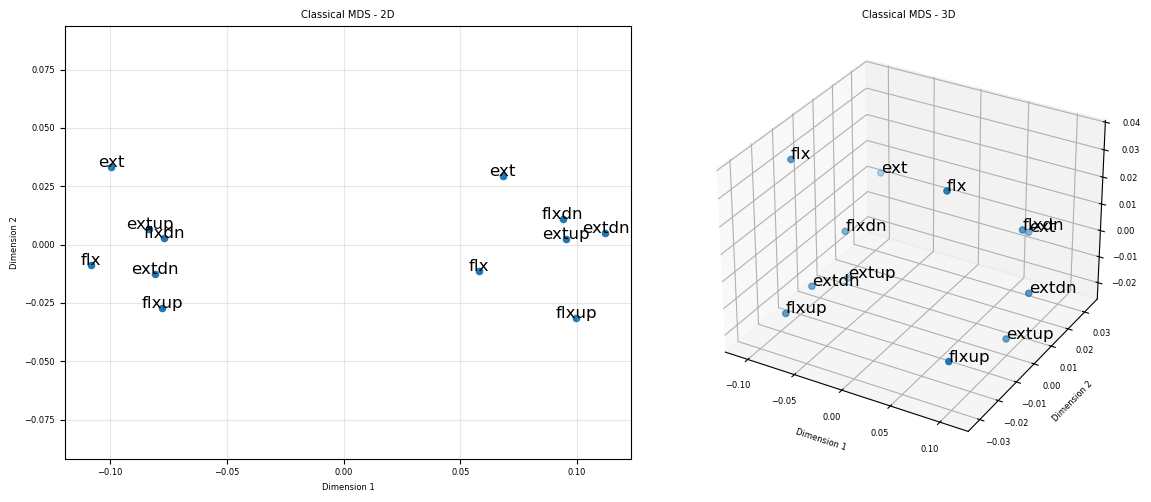

In [54]:
import numpy as np
import plotly.graph_objects as go

def plot_mds_3d_interactive(coords_3d, labels=None):
    """
    Create an interactive 3D scatter plot for MDS results.
    
    Parameters:
    -----------
    coords_3d : numpy.array
        3D coordinates from MDS (N x 3)
    labels : list or None
        Labels for each point (default: numerical indices)
    """
    if labels is None:
        labels = [str(i) for i in range(len(coords_3d))]
    
    fig = go.Figure(data=[go.Scatter3d(
        x=coords_3d[:, 0],
        y=coords_3d[:, 1],
        z=coords_3d[:, 2],
        mode='markers+text',
        marker=dict(
            size=8,
            color=coords_3d[:, 2],  # Color by z-coordinate
            colorscale='Viridis',
            showscale=True,
            colorbar=dict(title="Dimension 3")
        ),
        text=labels,
        textposition="top center",
        textfont=dict(size=12),
        hovertemplate='<b>%{text}</b><br>' +
                      'Dim 1: %{x:.3f}<br>' +
                      'Dim 2: %{y:.3f}<br>' +
                      'Dim 3: %{z:.3f}<br>' +
                      '<extra></extra>'
    )])
    
    fig.update_layout(
        title='Interactive 3D MDS Visualization',
        scene=dict(
            xaxis_title='Dimension 1',
            yaxis_title='Dimension 2',
            zaxis_title='Dimension 3',
            camera=dict(
                eye=dict(x=1.5, y=1.5, z=1.5)
            )
        ),
        width=800,
        height=700,
        hovermode='closest'
    )
    
    return fig

def classical_mds(D, n_components=2):
    """
    Classical Multidimensional Scaling (MDS) on a dissimilarity matrix.
    
    Also known as Principal Coordinates Analysis (PCoA) or Torgerson's scaling.
    
    Parameters:
    -----------
    D : numpy.array
        Symmetric dissimilarity/distance matrix (N x N)
    n_components : int, default=2
        Number of dimensions for the output (2 or 3 for visualization)
    
    Returns:
    --------
    Y : numpy.array
        Configuration matrix (N x n_components) with embedded coordinates
    eigenvalues : numpy.array
        Eigenvalues corresponding to the dimensions
    """
    # Number of points
    n = len(D)
    
    # Centering matrix
    H = np.eye(n) - np.ones((n, n)) / n
    
    # Double centering: B = -0.5 * H * D^2 * H
    B = -H.dot(D**2).dot(H) / 2
    
    # Eigendecomposition
    eigenvalues, eigenvectors = np.linalg.eigh(B)
    
    # Sort by eigenvalue in descending order
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    # Select only positive eigenvalues and corresponding eigenvectors
    positive_idx = eigenvalues > 0
    eigenvalues = eigenvalues[positive_idx]
    eigenvectors = eigenvectors[:, positive_idx]
    
    # Compute coordinates for the requested number of components
    n_components = min(n_components, len(eigenvalues))
    Y = eigenvectors[:, :n_components] @ np.diag(np.sqrt(eigenvalues[:n_components]))
    
    return Y, eigenvalues[:n_components]


np.random.seed(42)
tmp = RDMs_unimanual[(RDMs_unimanual['region']=='PMd')]
labels = tmp['labels'].values[0]
D = tmp['D^2'].to_list()
D = np.array(D)
D = np.sign(D) * np.sqrt(np.abs(D))
D = np.mean(D, axis=0)
D = np.abs(D)

# Perform classical MDS to 2D
coords_2d, eigenvals_2d = classical_mds(D, n_components=2)
print("2D coordinates:")
print(coords_2d)
print("\nEigenvalues:", eigenvals_2d)

# Perform classical MDS to 3D
coords_3d, eigenvals_3d = classical_mds(D, n_components=3)
print("\n3D coordinates:")
print(coords_3d)
print("\nEigenvalues:", eigenvals_3d)

# Optional: Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# 2D plot
plt.subplot(121)
plt.scatter(coords_2d[:, 0], coords_2d[:, 1], s=20)
for i in range(len(coords_2d)):
    plt.annotate(f'{labels[i]}', (coords_2d[i, 0], coords_2d[i, 1]), 
                fontsize=12, ha='center')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Classical MDS - 2D')
plt.grid(True, alpha=0.3)
plt.axis('equal')

# 3D plot
from mpl_toolkits.mplot3d import Axes3D
ax = plt.subplot(122, projection='3d')
ax.scatter(coords_3d[:, 0], coords_3d[:, 1], coords_3d[:, 2], s=20)
for i in range(len(coords_3d)):
    ax.text(coords_3d[i, 0], coords_3d[i, 1], coords_3d[i, 2], 
            f'{labels[i]}', fontsize=12)
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
ax.set_title('Classical MDS - 3D')

plt.tight_layout()
plt.show()

# Create labels (e.g., condition names)
# labels = [f'Condition {i+1}' for i in range(12)]
labels = tmp['labels'].values[0]
# Plot
fig = plot_mds_3d_interactive(coords_3d, labels=labels)
fig.show()




# Is the sturcture similar across hemisphere?

M1 L full average contra-ipsi correlation: r = 0.28
M1 R full average contra-ipsi correlation: r = 0.31
S1 L full average contra-ipsi correlation: r = 0.30
S1 R full average contra-ipsi correlation: r = 0.23
PMd L full average contra-ipsi correlation: r = 0.70
PMd R full average contra-ipsi correlation: r = 0.17
PMv L full average contra-ipsi correlation: r = 0.50
PMv R full average contra-ipsi correlation: r = 0.44
SMA L full average contra-ipsi correlation: r = 0.11
SMA R full average contra-ipsi correlation: r = 0.16
SPLa L full average contra-ipsi correlation: r = 0.80
SPLa R full average contra-ipsi correlation: r = 0.63
SPLp L full average contra-ipsi correlation: r = 0.70
SPLp R full average contra-ipsi correlation: r = 0.28
V1 L full average contra-ipsi correlation: r = 0.65
V1 R full average contra-ipsi correlation: r = 0.83
M1 L2L:
    contra-contra: t=2.56, p=0.0267
    contra-ipsi: t=4.07, p=0.0018
    ipsi-ipsi: t=-0.33, p=0.7511
    ipsi-contra: t=1.55, p=0.1502
M1 L2R:
 

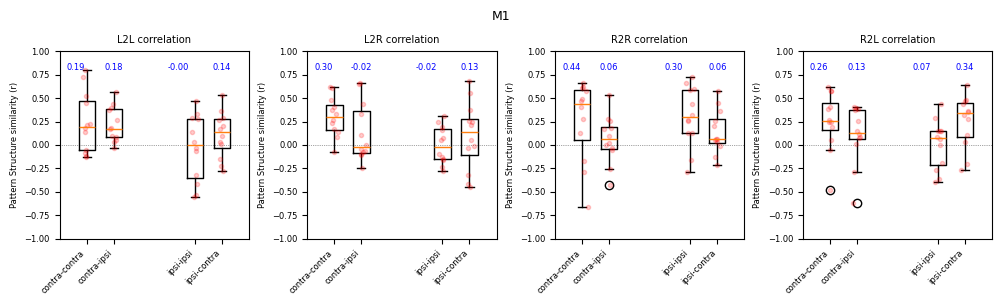

S1 L2L:
    contra-contra: t=2.48, p=0.0305
    contra-ipsi: t=4.11, p=0.0017
    ipsi-ipsi: t=-0.63, p=0.5430
    ipsi-contra: t=1.11, p=0.2893
S1 L2R:
    contra-contra: t=3.25, p=0.0077
    contra-ipsi: t=1.40, p=0.1879
    ipsi-ipsi: t=-1.05, p=0.3178
    ipsi-contra: t=0.58, p=0.5713
S1 R2R:
    contra-contra: t=2.45, p=0.0324
    contra-ipsi: t=0.30, p=0.7715
    ipsi-ipsi: t=3.45, p=0.0055
    ipsi-contra: t=1.64, p=0.1297
S1 R2L:
    contra-contra: t=3.68, p=0.0036
    contra-ipsi: t=0.15, p=0.8831
    ipsi-ipsi: t=0.58, p=0.5739
    ipsi-contra: t=2.97, p=0.0128


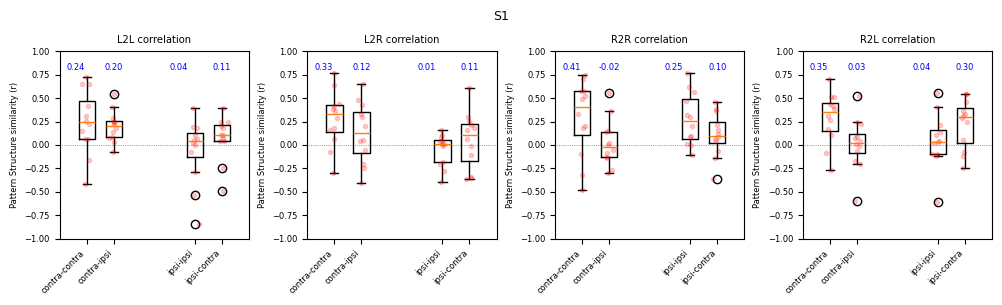

PMd L2L:
    contra-contra: t=2.62, p=0.0238
    contra-ipsi: t=3.74, p=0.0033
    ipsi-ipsi: t=2.30, p=0.0420
    ipsi-contra: t=6.03, p=0.0001
PMd L2R:
    contra-contra: t=2.66, p=0.0222
    contra-ipsi: t=0.94, p=0.3658
    ipsi-ipsi: t=3.42, p=0.0057
    ipsi-contra: t=2.12, p=0.0571
PMd R2R:
    contra-contra: t=2.33, p=0.0399
    contra-ipsi: t=0.92, p=0.3776
    ipsi-ipsi: t=2.64, p=0.0231
    ipsi-contra: t=0.65, p=0.5307
PMd R2L:
    contra-contra: t=2.96, p=0.0130
    contra-ipsi: t=2.09, p=0.0606
    ipsi-ipsi: t=1.73, p=0.1113
    ipsi-contra: t=1.66, p=0.1248


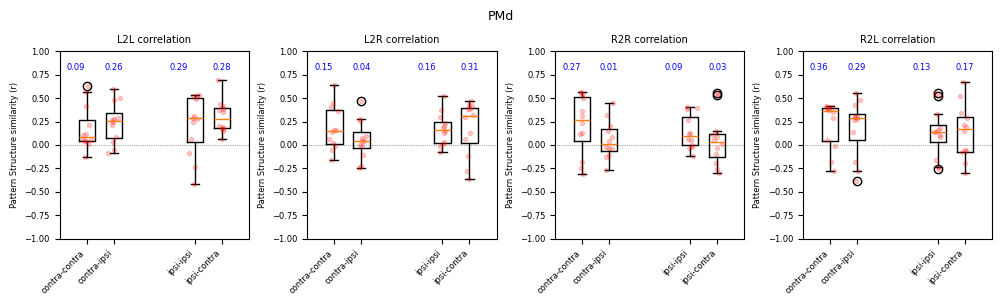

PMv L2L:
    contra-contra: t=1.14, p=0.2774
    contra-ipsi: t=1.72, p=0.1138
    ipsi-ipsi: t=2.81, p=0.0169
    ipsi-contra: t=2.16, p=0.0537
PMv L2R:
    contra-contra: t=1.68, p=0.1220
    contra-ipsi: t=1.17, p=0.2658
    ipsi-ipsi: t=0.20, p=0.8468
    ipsi-contra: t=3.25, p=0.0077
PMv R2R:
    contra-contra: t=0.66, p=0.5257
    contra-ipsi: t=0.99, p=0.3425
    ipsi-ipsi: t=0.19, p=0.8513
    ipsi-contra: t=0.35, p=0.7359
PMv R2L:
    contra-contra: t=1.31, p=0.2176
    contra-ipsi: t=1.58, p=0.1424
    ipsi-ipsi: t=0.08, p=0.9345
    ipsi-contra: t=0.69, p=0.5063


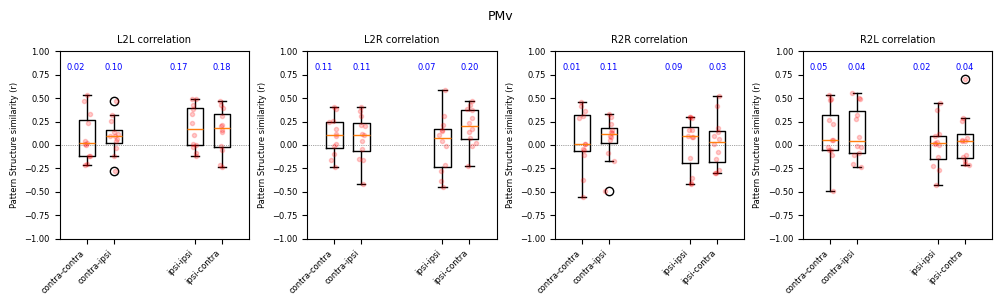

SMA L2L:
    contra-contra: t=1.91, p=0.0824
    contra-ipsi: t=1.77, p=0.1043
    ipsi-ipsi: t=2.43, p=0.0332
    ipsi-contra: t=0.73, p=0.4814
SMA L2R:
    contra-contra: t=1.61, p=0.1353
    contra-ipsi: t=2.25, p=0.0458
    ipsi-ipsi: t=0.07, p=0.9484
    ipsi-contra: t=3.13, p=0.0095
SMA R2R:
    contra-contra: t=1.75, p=0.1079
    contra-ipsi: t=2.28, p=0.0432
    ipsi-ipsi: t=1.06, p=0.3129
    ipsi-contra: t=0.74, p=0.4720
SMA R2L:
    contra-contra: t=1.99, p=0.0726
    contra-ipsi: t=2.12, p=0.0575
    ipsi-ipsi: t=0.15, p=0.8870
    ipsi-contra: t=1.84, p=0.0936


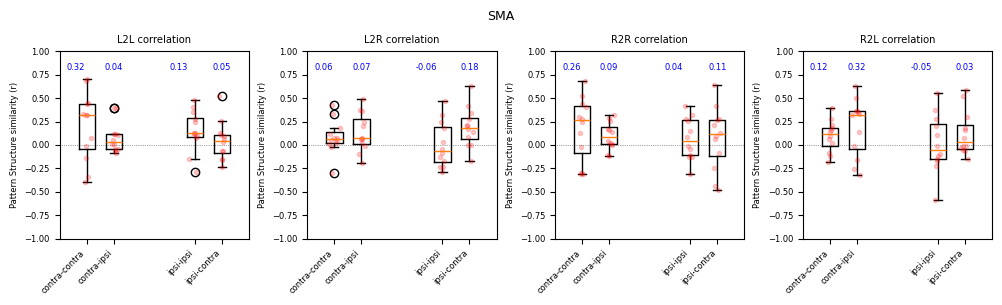

SPLa L2L:
    contra-contra: t=2.52, p=0.0282
    contra-ipsi: t=4.17, p=0.0016
    ipsi-ipsi: t=2.64, p=0.0228
    ipsi-contra: t=3.25, p=0.0078
SPLa L2R:
    contra-contra: t=3.34, p=0.0066
    contra-ipsi: t=1.76, p=0.1057
    ipsi-ipsi: t=2.42, p=0.0337
    ipsi-contra: t=2.51, p=0.0291
SPLa R2R:
    contra-contra: t=2.22, p=0.0483
    contra-ipsi: t=3.69, p=0.0036
    ipsi-ipsi: t=2.41, p=0.0346
    ipsi-contra: t=2.20, p=0.0500
SPLa R2L:
    contra-contra: t=3.26, p=0.0076
    contra-ipsi: t=2.25, p=0.0456
    ipsi-ipsi: t=1.42, p=0.1842
    ipsi-contra: t=1.86, p=0.0899


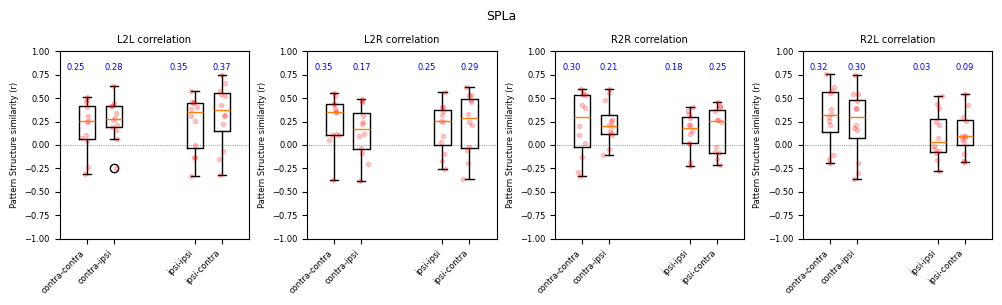

SPLp L2L:
    contra-contra: t=2.25, p=0.0457
    contra-ipsi: t=2.06, p=0.0640
    ipsi-ipsi: t=2.45, p=0.0320
    ipsi-contra: t=3.18, p=0.0087
SPLp L2R:
    contra-contra: t=2.02, p=0.0684
    contra-ipsi: t=1.89, p=0.0857
    ipsi-ipsi: t=2.20, p=0.0502
    ipsi-contra: t=3.19, p=0.0086
SPLp R2R:
    contra-contra: t=2.78, p=0.0178
    contra-ipsi: t=2.37, p=0.0374
    ipsi-ipsi: t=2.95, p=0.0131
    ipsi-contra: t=1.85, p=0.0912
SPLp R2L:
    contra-contra: t=3.92, p=0.0024
    contra-ipsi: t=2.61, p=0.0244
    ipsi-ipsi: t=2.45, p=0.0321
    ipsi-contra: t=1.39, p=0.1935


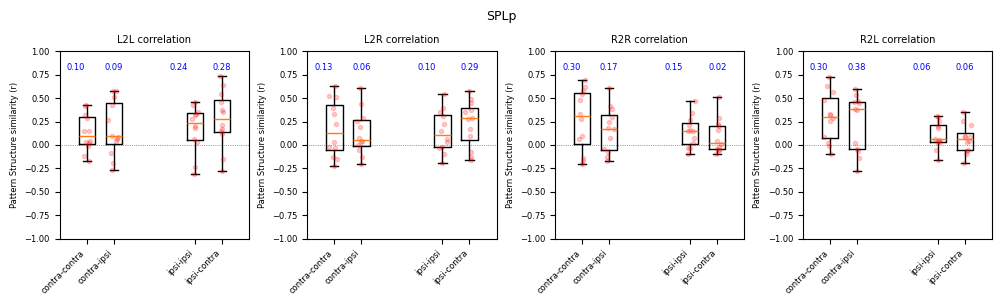

V1 L2L:
    contra-contra: t=6.98, p=0.0000
    contra-ipsi: t=12.97, p=0.0000
    ipsi-ipsi: t=5.53, p=0.0002
    ipsi-contra: t=3.66, p=0.0037
V1 L2R:
    contra-contra: t=8.34, p=0.0000
    contra-ipsi: t=10.12, p=0.0000
    ipsi-ipsi: t=4.76, p=0.0006
    ipsi-contra: t=5.41, p=0.0002
V1 R2R:
    contra-contra: t=14.24, p=0.0000
    contra-ipsi: t=12.32, p=0.0000
    ipsi-ipsi: t=6.33, p=0.0001
    ipsi-contra: t=5.59, p=0.0002
V1 R2L:
    contra-contra: t=9.25, p=0.0000
    contra-ipsi: t=17.97, p=0.0000
    ipsi-ipsi: t=6.23, p=0.0001
    ipsi-contra: t=5.35, p=0.0002


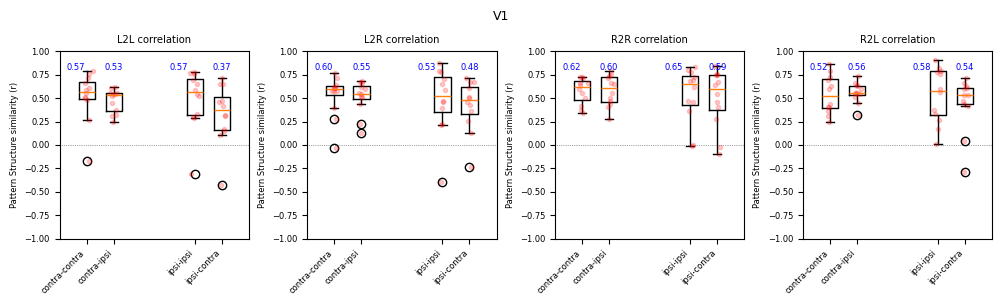

In [5]:
def cka(G1, G2):
    '''
    Compute the Centered Kernel Alignment (CKA) between two kernel (similarity) matrices G1 and G2.
    '''
    # Center the matrices
    n = G1.shape[0]
    H = np.eye(n) - np.ones((n, n)) / n
    G1_centered = H @ G1 @ H
    G2_centered = H @ G2 @ H

    # Compute the CKA
    cka = np.sum(G1_centered * G2_centered) / (np.sqrt(np.sum(G1_centered ** 2)) * np.sqrt(np.sum(G2_centered ** 2)))
    return cka

df = {'region': [], 'hem': [], 'within_hem': [], 'sn': [], 'r_contra_contra': [], 'r_ipsi_ipsi': [], 'r_contra_ipsi': [], 'r_ipsi_contra': []}

regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp','V1']
hem = ['L', 'R']
for region in regions:
    # ============================= Within Hem =============================
    for i, h in enumerate(hem):
        tmp = RDMs_unimanual[(RDMs_unimanual['region']==region) & (RDMs_unimanual['hem']==h)]
        G = tmp['G'].to_list()
        G = np.array(G)
        # N-1 cross validation:
        N = np.shape(G)[0]
        r_contra_contra, r_ipsi_ipsi, r_contra_ipsi, r_ipsi_contra = [], [], [], []
        for i in range(N):
            G_mean = np.mean(np.delete(G, i, axis=0), axis=0)
            # G_mean = pcm.G_to_dist(G_mean)
            G_sub = G[i, :, :]
            # G_sub = pcm.G_to_dist(G_sub)

            # imshow of G_mean and G_sub with subplots(1,2):
            # if region == 'M1':
            #     cmap = 'RdBu_r'
            #     fig, ax = plt.subplots(1,2, figsize=(3.5,2))
            #     vmin = -np.max(np.abs(G_sub))
            #     vmax = np.max(np.abs(G_sub))
            #     ax[0].imshow(G_sub, cmap=cmap, vmin=vmin, vmax=vmax)
            #     ax[0].set_title('G_sub')
            #     vmin = -np.max(np.abs(G_mean))
            #     vmax = np.max(np.abs(G_mean))
            #     ax[1].imshow(G_mean, cmap=cmap, vmin=vmin, vmax=vmax)
            #     ax[1].set_title('G_mean')
            #     plt.suptitle(f'sn {tmp["sn"].values[i]} - {region}_{h}', fontsize=9)
            #     plt.tight_layout()
            #     plt.show()

            # contra-contra:
            G1 = G_mean[:6, :6]
            G2 = G_sub[:6, :6]
            r = cka(G1, G2)
            r_contra_contra.append(r)

            # ipsi-ipsi:
            G1 = G_mean[6:, 6:]
            G2 = G_sub[6:, 6:]
            r = cka(G1, G2)
            r_ipsi_ipsi.append(r)

            # contra-ipsi:
            G1 = G_mean[6:, 6:]
            G2 = G_sub[:6, :6]
            r = cka(G1, G2)
            r_contra_ipsi.append(r)

            # ipsi-contra:
            G1 = G_mean[:6, :6]
            G2 = G_sub[6:, 6:]
            r = cka(G1, G2)
            r_ipsi_contra.append(r)

        df['region'].append(region)
        df['hem'].append(f'{h}2{h}')
        df['within_hem'].append('within')
        df['sn'].append(list(tmp['sn']))
        df['r_contra_contra'].append(r_contra_contra)
        df['r_ipsi_ipsi'].append(r_ipsi_ipsi)
        df['r_contra_ipsi'].append(r_contra_ipsi)
        df['r_ipsi_contra'].append(r_ipsi_contra)

        # also estimate full average corrleation:
        G_mean = np.mean(G, axis=0)
        G1 = G_mean[:6, :6] # contra
        G2 = G_mean[6:, 6:] # ipsi
        r = cka(G1, G2)
        print(f'{region} {h} full average contra-ipsi correlation: r = {r:.2f}')
    
    # Between Hemisphere Correlation:
    tmp = RDMs_unimanual[(RDMs_unimanual['region']==region) & (RDMs_unimanual['hem']=='L')]
    G_L = tmp['G'].to_list()
    G_L = np.array(G_L)
    
    tmp = RDMs_unimanual[(RDMs_unimanual['region']==region) & (RDMs_unimanual['hem']=='R')]
    G_R = tmp['G'].to_list()
    G_R = np.array(G_R)

    # ============================= L to R =============================
    # N-1 cross validation:
    N = np.shape(G_L)[0]
    r_contra_contra, r_ipsi_ipsi, r_contra_ipsi, r_ipsi_contra = [], [], [], []
    for i in range(N):
        G_mean_R = np.mean(np.delete(G_R, i, axis=0), axis=0)
        # G_mean_R = pcm.G_to_dist(G_mean_R)
        G_sub_L = G_L[i, :, :]
        # G_sub_L = pcm.G_to_dist(G_sub_L)

        # contra-contra:
        G1 = G_mean_R[:6, :6]
        G2 = G_sub_L[:6, :6]
        r = cka(G1, G2)
        r_contra_contra.append(r)

        # ipsi-ipsi:
        G1 = G_mean_R[6:, 6:]
        G2 = G_sub_L[6:, 6:]
        r = cka(G1, G2)
        r_ipsi_ipsi.append(r)

        # contra-ipsi:
        G1 = G_mean_R[6:, 6:]
        G2 = G_sub_L[:6, :6]
        r = cka(G1, G2)
        r_contra_ipsi.append(r)

        # ipsi-contra:
        G1 = G_mean_R[:6, :6]
        G2 = G_sub_L[6:, 6:]
        r = cka(G1, G2)
        r_ipsi_contra.append(r)
    df['region'].append(region)
    df['hem'].append('L2R')
    df['within_hem'].append('between')
    df['sn'].append(list(tmp['sn']))
    df['r_contra_contra'].append(r_contra_contra)
    df['r_ipsi_ipsi'].append(r_ipsi_ipsi)
    df['r_contra_ipsi'].append(r_contra_ipsi)
    df['r_ipsi_contra'].append(r_ipsi_contra)

    # ============================= R to L =============================
    # N-1 cross validation:
    N = np.shape(G_L)[0]
    r_contra_contra, r_ipsi_ipsi, r_contra_ipsi, r_ipsi_contra = [], [], [], []
    for i in range(N):
        G_mean_L = np.mean(np.delete(G_L, i, axis=0), axis=0)
        # G_mean_L = pcm.G_to_dist(G_mean_L)
        G_sub_R = G_R[i, :, :]
        # G_sub_R = pcm.G_to_dist(G_sub_R)

        # contra-contra:
        G1 = G_mean_L[:6, :6]
        G2 = G_sub_R[:6, :6]
        r = cka(G1, G2)
        r_contra_contra.append(r)

        # ipsi-ipsi:
        G1 = G_mean_L[6:, 6:]
        G2 = G_sub_R[6:, 6:]
        r = cka(G1, G2)
        r_ipsi_ipsi.append(r)

        # contra-ipsi:
        G1 = G_mean_L[6:, 6:]
        G2 = G_sub_R[:6, :6]
        r = cka(G1, G2)
        r_contra_ipsi.append(r)

        # ipsi-contra:
        G1 = G_mean_L[:6, :6]
        G2 = G_sub_R[6:, 6:]
        r = cka(G1, G2)
        r_ipsi_contra.append(r)
    df['region'].append(region)
    df['hem'].append('R2L')
    df['within_hem'].append('between')
    df['sn'].append(list(tmp['sn']))
    df['r_contra_contra'].append(r_contra_contra)
    df['r_ipsi_ipsi'].append(r_ipsi_ipsi)
    df['r_contra_ipsi'].append(r_contra_ipsi)
    df['r_ipsi_contra'].append(r_ipsi_contra)
df = pd.DataFrame(df)

# PLOT:
# In one box plot:
# First within hemisphere boxplot, contra-contra, contra-ipsi, ipsi-ipsi, ipsi-contra
# Then between hemisphere boxplot, contra-contra, contra-ipsi, ipsi-ipsi, ipsi-contra
plt.rcParams.update({'font.size': 6})
for region in regions:
    fig, ax = plt.subplots(1,4, figsize=(10,3))
    name = f'{region}'
    # main title:
    plt.suptitle(f'{name}', fontsize=9)
    for i, wh in enumerate(['L2L', 'L2R', 'R2R', 'R2L']):
        plt.sca(ax[i])
        tmp = df[(df['region']==region) & (df['hem']==wh)]
        r_contra_contra = tmp['r_contra_contra'].values[0]
        r_ipsi_ipsi = tmp['r_ipsi_ipsi'].values[0]
        r_contra_ipsi = tmp['r_contra_ipsi'].values[0]
        r_ipsi_contra = tmp['r_ipsi_contra'].values[0]
        data_plot = [r_contra_contra, r_contra_ipsi, r_ipsi_ipsi, r_ipsi_contra]
        ax[i].boxplot(data_plot, positions=[1,1.5,3,3.5], widths=0.3)
        ax[i].axhline(0, color='k', linestyle=':', linewidth=0.5, alpha=0.7)
        ax[i].set_xticks([1,1.5,3,3.5])
        ax[i].set_xticklabels(['contra-contra', 'contra-ipsi', 'ipsi-ipsi', 'ipsi-contra'], rotation=45, ha='right')
        ax[i].set_ylabel('Pattern Structure similarity (r)')
        ax[i].set_ylim([-1, 1])
        ax[i].set_title(f'{wh} correlation')
        # ax[i].set_yticks(np.arange(-0.1, 1.1, 0.2))

        # individual data points:
        for j in range(len(data_plot)):
            y = data_plot[j]
            x = np.random.normal([1,1.5,3,3.5][j], 0.04, size=len(y))  # add some random "jitter" to the x-axis
            ax[i].plot(x, y, 'r.', alpha=0.2)

        # print mean values:
        for j in range(len(data_plot)):
            y = data_plot[j]
            median_val = np.median(y)
            ax[i].text([0.8,1.5,2.7,3.5][j], 0.8, f'{median_val:.2f}', ha='center', fontsize=6, color='blue')
        
        # test vs 0 for each box:
        print(f'{region} {wh}:')
        for j in range(len(data_plot)):
            y = data_plot[j]
            t, p = scipy.stats.ttest_1samp(y, 0)
            print(f'    {["contra-contra", "contra-ipsi", "ipsi-ipsi", "ipsi-contra"][j]}: t={t:.2f}, p={p:.4f}')
    plt.tight_layout()
    plt.show()

